# Convolutional Neural Networks (with TensorFlow)

DMLP(깊은 다층 퍼셉트론)는 완전연결 구조이어서 가중치가 너무 많아 복잡도가 높았다. 따라서 학습이 매우 더디고, 과잉적합에 빠질 가능성도 크다. 이에 반해, CNN(컨볼루션 신경망)은 부분연결 구조이기에 모델의 복잡도를 획기적으로 낮출 수 있다. DMLP에 입력되는 데이터는 일렬로 늘어선 벡터 구조에 불과하나, CNN은 영상과 같은 행렬 구조, 3차원 이상의 텐서 구조를 처리할 수 있다. 또한 가변하는 크기의 입력도 처리할 수 있다는 장점이 있다.

## 기본 도구 설치

첫번째로, tensorflow 를 설치하고, import한다.

In [1]:
!pip install --upgrade tensorflow

     |████████████████████████████████| 588.3 MB 10 kB/s /s eta 0:00:01
     |████████████████████████████████| 1.7 MB 52.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.4 MB 52.4 MB/s eta 0:00:01
     |████████████████████████████████| 6.0 MB 50.2 MB/s eta 0:00:01
     |████████████████████████████████| 124 kB 80.5 MB/s eta 0:00:01
     |████████████████████████████████| 439 kB 65.2 MB/s eta 0:00:01
     |████████████████████████████████| 14.1 MB 21.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 50.4 MB/s eta 0:00:01
ERROR: tensorflow-gpu 2.2.1 has requirement h5py<2.11.0,>=2.10.0, but you'll have h5py 3.7.0 which is incompatible.
ERROR: tensorflow-gpu 2.2.1 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.21.6 which is incompatible.
ERROR: tensorflow-gpu 2.2.1 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.11.0 which is incompatible.
ERROR: tensorflow-gpu 2.2.1 has requirement tensorflow-estimator<2.3.0,>=2.2.0, 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [2]:
import tensorflow
from  tensorflow import keras
print('TensorFlow version:',tensorflow.__version__)
print('Keras version:',keras.__version__)

2022-12-03 06:50:42.691360: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 06:50:43.756469: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-03 06:50:43.756583: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-03 06:50:43.756595: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

TensorFlow version: 2.11.0
Keras version: 2.11.0


## 데이터 찾아보기

기하학적 형상을 분류하는 CNN에 대하여 훈련을 진행한다. 아래 모양들을 살펴보자.

3 classes:
['circle', 'square', 'triangle']


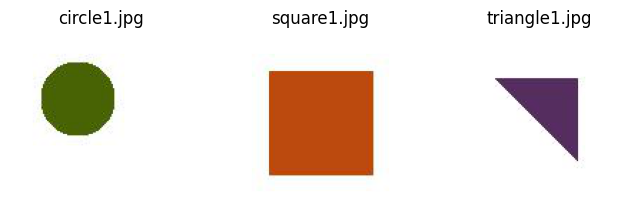

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline

data_folder = 'data/shapes'

classes = os.listdir(data_folder)
classes.sort()
print(len(classes), 'classes:')
print(classes)

fig = plt.figure(figsize=(8, 12))
i = 0
for sub_dir in os.listdir(data_folder):
    i+=1
    img_file = os.listdir(os.path.join(data_folder,sub_dir))[0]
    img_path = os.path.join(data_folder, sub_dir, img_file)
    img = mpimg.imread(img_path)
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file)
plt.show()

## 데이터 준비

위 형상들의 값을 255로 나누어, 0과 1 사이의 소수로 정규화한다.
데이터 중 70%는 교육하고, 30%는 검정한다.
데이터에 "hot-encoded" 레이블을 설정하여, 레이블과 각각의 모형들이 속한 클래스가 연결되도록 구성한다.

+) One-Hot Encoding : 표현하고자 하는 데이터를 목록화하여 0, 1의 이진값으로 만드는 방법이다.


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 30

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, # pixel값 설정
                             validation_split=0.3) # 30% 의 이미지 = validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # raining data 세팅

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # validation data 세팅

classnames = list(train_generator.class_indices.keys())
print('Data generators ready')

Getting Data...
Preparing training dataset...
Found 840 images belonging to 3 classes.
Preparing validation dataset...
Found 360 images belonging to 3 classes.
Data generators ready


## CNN 정의하기

CNN을 정의하고, 모델을 추가하여 분류한다.

In [5]:
# Define CNN 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Define the model (층별로)
model = Sequential()

# imput layer = 영상 수신, 32, 6x6필터를 사용하는 CNN 적용
model.add(Conv2D(32, (6, 6), input_shape=train_generator.image_shape, activation='relu'))

# pooling layer = 2x2 로 풀링하는 층 추가
model.add(MaxPooling2D(pool_size=(2,2)))

#필요한 만큼 풀링층과 convolution 추가
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 다른 집합
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 드롭아웃(입력층 이나, 은닉층에서의 일부 뉴런을 과잉적합을 피하기 위해 생략한다.)
model.add(Dropout(0.2))

# 평탄화 
model.add(Flatten())

# 완전 연결층 생성
# (softmax 함수 이용)
model.add(Dense(train_generator.num_classes, activation='softmax'))

# 층들을 모두 정의하면, 다중 클래스 분류를 위한 모델을 추가한다
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 123, 123, 32)      3488      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 61, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 32)        36896     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 32)        36896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 32)       0

## 학습시키기

CNN을 정의한 후, 검증을 위한 데이터는 제외하고 나머지 데이터들을 학습한다. 5번의 학습을 통해, 각 모델의 손실을 측정하고, 이를 줄이기 위하여 가중치를 조절한다.

+) 실제 컨볼루션 신경망은 5번보다 훨씬 많은 반복학습을 진행한다.

In [6]:
# 반봅학습 진행/ 학습에 대한 진행도를 표시함.
num_epochs = 5
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/5
28/28 [==============================] - 34s 1s/step - loss: 0.8998 - accuracy: 0.5143 - val_loss: 0.4920 - val_accuracy: 0.6917
Epoch 2/5
28/28 [==============================] - 28s 1s/step - loss: 0.3340 - accuracy: 0.8393 - val_loss: 0.1352 - val_accuracy: 0.9694
Epoch 3/5
28/28 [==============================] - 29s 1s/step - loss: 0.1185 - accuracy: 0.9560 - val_loss: 0.0318 - val_accuracy: 0.9944
Epoch 4/5
28/28 [==============================] - 28s 993ms/step - loss: 0.0225 - accuracy: 0.9964 - val_loss: 0.0106 - val_accuracy: 0.9972
Epoch 5/5
28/28 [==============================] - 27s 966ms/step - loss: 0.0135 - accuracy: 0.9940 - val_loss: 0.0055 - val_accuracy: 1.0000


## 손실 확인

모델이 반복훈련을 진행함에 따라, 이에 대한 손실이 감소했음을 그래프를 통해 알 수 있다. 또한  과잉적합에 빠졌는지 판단하기 위해 이러한 그래프를 사용한다. 

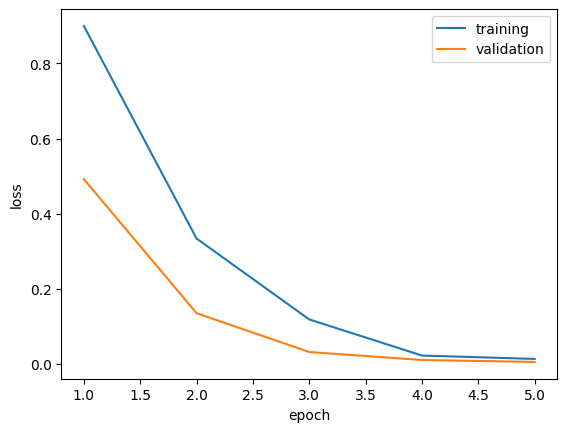

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## 분류 모델 성능 평가 지표

성능을 테스트 데이터 기반이 아닌, 좀더 자세히 알아보기 위해 오차 행렬을 나타내 본다.


Generating predictions from validation data...
1/1 [==============================] - 0s 84ms/step


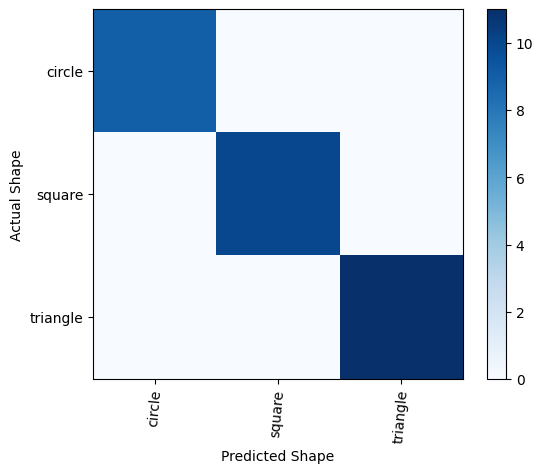

In [11]:
# 사이킷 런을 이용하여 행렬을 나타낸다.
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

print("Generating predictions from validation data...")
# 이미지와 라벨을 가지고 온다.
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]

# 클래스 예측
class_probabilities = model.predict(x_test)

# 최대 확률값 가져오기
predictions = np.argmax(class_probabilities, axis=1)

# 이 실제 레이블들은 hot-encoding 되므로, 이에 해당하는 값을 가져온다
true_labels = np.argmax(y_test, axis=1)

# 오차행렬을 나타낸다.
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

## 학습모델 저장


In [12]:
# 학습모델 저장
modelFileName = 'models/shape_classifier.h5'
model.save(modelFileName)
del model  # 기존 모델 삭제
print('model saved as', modelFileName)

model saved as models/shape_classifier.h5


## 학습 모델 이용

위에서 저장한 모델을 이용하여 다른 클래스를 예측할 수 있다.

1/1 [==============================] - 0s 67ms/step
triangle


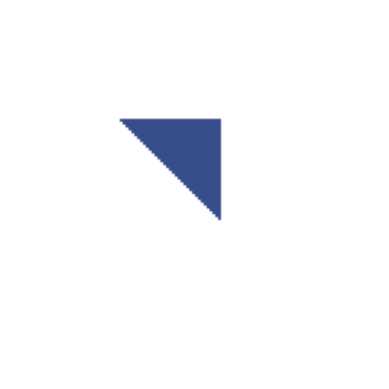

In [13]:
from tensorflow.keras import models
import numpy as np
from random import randint
import os
%matplotlib inline

# 이미지 예측을 위한 함수 설정.
def predict_image(classifier, image):
    from tensorflow import convert_to_tensor
    # 1개의 이미지 배열을 생성한다.
    imgfeatures = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])

    # 입력값과 학습데이터를 일치시킨다.
    # 위와 같이 픽셀값을 정규화한다.
    imgfeatures = imgfeatures.astype('float32')
    imgfeatures /= 255
    
    # 모델을 이용한다.
    class_probabilities = classifier.predict(imgfeatures)
    
    # 가장 높은 확률로 클래스 예측
    index = int(np.argmax(class_probabilities, axis=1)[0])
    return index

# 랜덤 이미지 생성 함수
def create_image (size, shape):
    from random import randint
    import numpy as np
    from PIL import Image, ImageDraw
    
    xy1 = randint(10,40)
    xy2 = randint(60,100)
    col = (randint(0,200), randint(0,200), randint(0,200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    if shape == 'circle':
        draw.ellipse([(xy1,xy1), (xy2,xy2)], fill=col)
    elif shape == 'triangle':
        draw.polygon([(xy1,xy1), (xy2,xy2), (xy2,xy1)], fill=col)
    else: # square
        draw.rectangle([(xy1,xy1), (xy2,xy2)], fill=col)
    del draw
    
    return np.array(img)

# 랜덤 테스트 이미지 생성
classnames = os.listdir(os.path.join('data', 'shapes'))
classnames.sort()
img = create_image ((128,128), classnames[randint(0, len(classnames)-1)])
plt.axis('off')
plt.imshow(img)

# 클래스 분류
model = models.load_model(modelFileName) # 저장된 모델 이용
class_idx = predict_image(model, img)
print (classnames[class_idx])